## Import stuff

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pickle
import os

In [2]:
from mysticetus import model_driven_reco
from mysticetus import synthesize_measurement_data
from mysticetus import plotting
from mysticetus.model_driven_reco import dist_model_grating_2D                     as _dist_model
from mysticetus.model_driven_reco import meas_model_far_field_intensity_and_psf_2D as _meas_model
from mysticetus.model_driven_reco import make_objective_2D_with_psf                as make_objective

## Wrap functions

In [3]:
def dist_model(params, domain):
    return _dist_model(params['sigma'], params['pitch'], params['fsize'], domain['xx'], domain['yy'])

def meas_model(params, dist, **kwargs):
    arti = kwargs['arti']
    meas = _meas_model(dist, **kwargs)
    meas += arti * (meas.sum()*mask.sum()/arti.size)
    return meas

## Synthesize 2D measurement data

In [4]:
# Define definition domain
xres    = 512
xmin    = 0.
xmax    = 10.
x       = np.linspace(xmin, xmax, xres, endpoint=False)

yres    = 32
ymin    = 0.
ymax    = 10.
y       = np.linspace(ymin, ymax, yres, endpoint= False)

xx, yy  = np.meshgrid(x, y)

domain  = {'xx':xx, 'yy':yy}

In [5]:
# Define number of measurements to synthesize
nmeas   = 2

# Draw random true distribution paramsets
#true_param_list = draw_paramsets(nmeas, **domain_scales(x))
#true_param_list = [{'pitch':3.2, 'fsize':0.9, 'sigma':0.3}, ]
true_param_list\
        = [{'pitch':0.2, 'fsize':0.07, 'sigma':0.0001}, 
           {'pitch':0.2, 'fsize':0.07, 'sigma':0.0001}, 
          ]

# Create true PSF
true_psf\
        = model_driven_reco.create_psf(xx, yy, 2.8)

# Create artifact
ixmin   = 200
ixmax   = 220
iymin   = 3
iymax   = 25
arti    = np.zeros(shape = xx.shape)
arti[iymin:iymax, ixmin:ixmax]\
        = np.random.rand(iymax-iymin, ixmax-ixmin)
mask    = arti==0

# Set up data synthesizer
s       = synthesize_measurement_data.Synthesizer(dist_model, meas_model, domain)

In [6]:
sm_list = []
measId  = 0
for true_params in true_param_list:
    m           = s(true_params, arti=arti, psf=true_psf)
    m.measId    = measId
    m.mask      = mask
    sm_list.append(m)
    measId      += 1

## Show measurement data

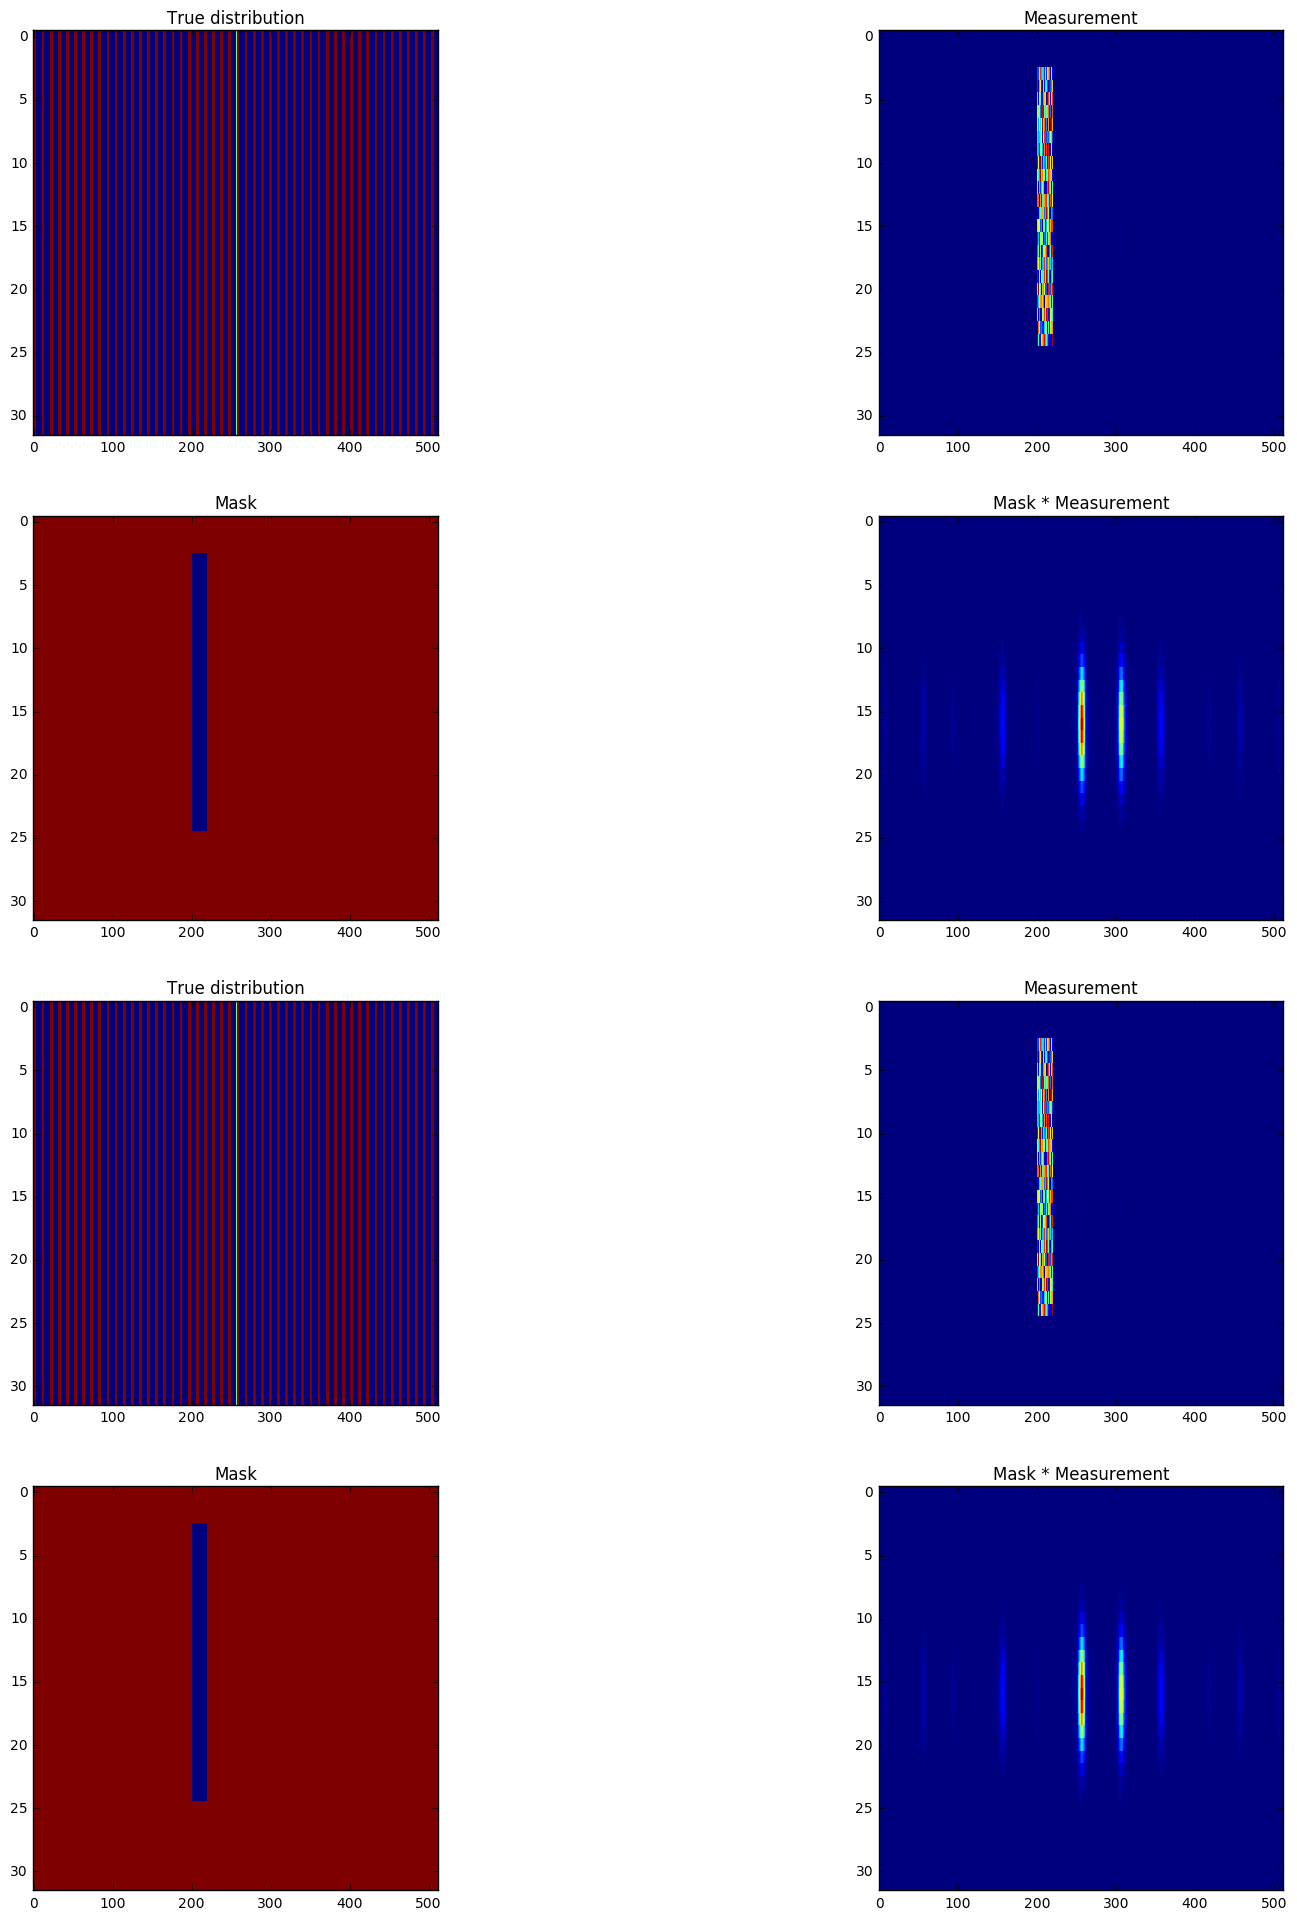

In [7]:
# Plot
fig     = plt.figure(figsize=(20, len(sm_list)*3*4))

ncases  = len(sm_list)
icase   = 0
for m in sm_list:
    plotting.show_measurement_data(m, ncases, icase, fig)
    icase   += 1

## Draw start parametersets

In [8]:
# Define number of start paramsets to draw
nstart = 1

# Draw
#start_params_list = draw_paramsets(nstart, ensemble=random_start_paramset, **domain_scales(x))
start_params_list = [{'pitch':0.201, 'fsize':0.079, 'sigma':0.0001}, ]


## Reconstruct from 2D measurement data

In [9]:
%%prun -rq

# Define number of basinhopping steps
niter = 1

class RawData:
    pass

# Initialize accept_test - enforces bounds on parameters during basinhopping
parambounds= ParamBounds([np.max(xx), np.max(xx), np.max(xx)], [0., 0., 0.])

psf = true_psf

results = []
for m in sm_list:
    startId = 0
    for start_params in start_params_list:
        results.append(RawData())
        results[-1].startId      = startId
        results[-1].m            = m
        results[-1].start_params = start_params
        
        meas        = m.meas
        mask        = m.mask
        xx, yy      = m.domain['xx'], m.domain['yy']
        p0          = [start_params['sigma'], start_params['pitch'], start_params['fsize']]

        # Make objective function
        obj        = make_objective(xx, yy, meas, **{'mask':mask, 'psf':psf})

        # Set up minimizer
        min_kwargs = {'method' : 'BFGS'}

        # Run reconstruction
        xs         = [p0, ]
        fs         = [obj(p0), ]
        accs       = [True, ]
        callback   = make_callback(xs, fs, accs, 'silent')
        ret        = basinhopping(obj, p0,
                                  T                = 10,
                                  stepsize         = 0.005,
                                  minimizer_kwargs = min_kwargs,
                                  niter            = niter,
                                  callback         = callback,
                                  accept_test      = parambounds)
        
        results[-1].xs = xs
        results[-1].fs = fs
        results[-1].accs = accs
        results[-1].bh_return = ret
        startId += 1

NameError: name 'ParamBounds' is not defined

In [ ]:
timing_results = _
timing_results.print_stats(15)

## Show 2D results

In [ ]:
class ResultProcessingPipeline(object):
    def __call__(self, result, interims, consts):
        opt_params  = {'sigma':result.bh_return.x[0],
                       'pitch':result.bh_return.x[1],
                       'fsize':result.bh_return.x[2]}
        interims['opt_dist']    = dist_model(opt_params, consts['domain'])
        interims['opt_meas']    = meas_model(opt_params, interims['opt_dist'], arti=np.zeros(shape=consts['arti'].shape), psf=consts['psf'])
        interims['acc_minima']  = model_driven_reco.accepted_minima_only(result.fs, result.accs)
        interims['true_dist']   = result.m.dist   if hasattr(result.m, 'dist')   else None
        interims['meas']        = result.m.meas
        interims['mask']        = result.m.mask   if hasattr(result.m, 'mask')   else None

In [ ]:
consts = {'domain':{'xx':xx, 'yy':yy}, 'arti':arti, 'psf':psf}
pr = ProcessResult(ResultProcessingPipeline(), consts)
rs = ResultShow(len(results), figsize=(20, 50), aspect=1)    
for result in results:
    rs(pr(result))

## Save raw data

In [ ]:
if False:
#if True:
    runId = 1
    for result in results:
        fn = 'synthetic_2D_grating_with_mask__result__runId_{:02}__measId_{:02}__startId_{:02}.pickle'.format(runId, result.synthetic.measId, result.startId)
        print(fn)
        i+=1
        
        if os.path.exists(fn):
            raise FileExistsError('Error: path exists!')
        
        with open(fn, 'wb') as handle:
            pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)